# This document was used to train and experiment with model from experiment_a2c.py

# Things that are different in this model 
- The model will share the same feature extraction layer with different options for head. 
- The model will carry over all the functionalities from the A2C agent. 


## Feature to stack previous states and action for input - memory 
- Change the input of the model by stacking previous plays 

## Training Schedule
- First train the value network on the rewards to make sure that it is predicting the rewards correctly, and then use it to get the policy. 

## More detailed training schedule (500 episodes each -> 500 * 5 = 2500 episodes for overall model)
1) Train the Backbone along with a simple critic head to have the backbone learn better representations. 
2) Freeze the Backbone and train the complex critic so that it can learn how to use the representations well. 
3) Train both the backbone and the critic together
4) Freeze the backbone and the critic and train the actor (might want to use delayed training for critic)
5) Train everything together!

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import torch.distributions as distributions

plt.style.use("tableau-colorblind10")
plt.rcParams.update({'font.size': 14})


In [3]:
# Import resources for the game env 
from engines.environment import HexChessEnv
from hexchess.players import RandomPlayer, GreedyPlayer
from engines.train_a2c import A2C, A2CLearning
from utils import plot_step_rewards, plot_episode_rewards
from engines.experiment_a2c import Critic, Actor, ResidualBackBone, SimpleCritic, AdvancedA2CLearning

pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
# Constants
base_path = os.path.join("assets", "a2c")
figs_path = os.path.join("figures", "a2c")
print(base_path, figs_path)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

assets/a2c figures/a2c
mps


In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Train the Backbone with Simple Critic

In [10]:

'''
We are going to use the SimpleCritic Model to focus training on the backbone!
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
critic_load_path = None
critic_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_simple_critic.pth"
backbone_load_path = None
backbone_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_backbone.pth"


# Environment parameters
opponent_class = GreedyPlayer
opponent_is_white = True
apply_negative_scores = False

# Critic parameters
input_dim = 256 


# BackBone parameters
input_channels = 6
hidden_dimensions = 256
residual_blocks = 6


# Critic Learning parameters
num_previous_states = 6
epochs = 13
episodes_per_epoch = 60
batch_size = 40
learning_rate = 1e-3
gamma = 0.25
max_steps = 100


# Prioritized Memory Replay parameters
memory_size = 80
sampling_priority_scale = 0.7
replace_samples = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = -1

# Model Training
n_iterations = 1

################
# Training
################

for iteration in range(n_iterations):
    print(f"Starting training iteration {iteration + 1}/{n_iterations}")

    env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores)

    if critic_load_path is not None:
        critic = SimpleCritic(input_dim=input_dim, model_path=critic_load_path)
    else:
        critic = SimpleCritic(input_dim=input_dim)

    if backbone_load_path is not None:
        backbone = ResidualBackBone(input_channels=input_channels, hidden_dimensions=hidden_dimensions, residual_blocks=residual_blocks, model_path=backbone_load_path)
    else: 
        backbone = ResidualBackBone(input_channels=input_channels, hidden_dimensions=hidden_dimensions, residual_blocks=residual_blocks)

    critic.to(device)
    backbone.to(device)


    # Learning system initialization
    learning_system = AdvancedA2CLearning(env=env, 
                                    critic=critic, 
                                    backbone=backbone, 
                                    num_previous_states=num_previous_states, 
                                    device=device, 
                                    epochs=epochs,
                                    episodes_per_epoch=episodes_per_epoch,
                                    batch_size=batch_size,
                                    learning_rate=learning_rate,
                                    gamma=gamma,
                                    max_steps=max_steps,
                                    memory_size=memory_size,
                                    simple_critic=True
                                    )


    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in critic.parameters():
            param.data = param.data.to(device='mps')

    # Calculate the number of trainable parameters
    critic_num_parameters = count_parameters(critic) 
    print(f"Number of trainable parameters in the Critic model: {critic_num_parameters}")

    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in backbone.parameters():
            param.data = param.data.to(device='mps')

    # Calculate the number of trainable parameters
    backbone_num_parameters = count_parameters(backbone) 
    print(f"Number of trainable parameters in the BackBone model: {backbone_num_parameters}")

    
    # Training
    rewards, losses = learning_system.train(sampling_prob_scale=sampling_priority_scale, 
                                            replace_samples=replace_samples, 
                                            priority_offset=priority_offset,  
                                            importance_sampling_beta=importance_sampling_beta_start)

    #Save Model
    learning_system.save(critic_save_path, backbone_save_path)

    print(f"Finished training iteration {iteration + 1}/{n_iterations}. Model saved.")

Device:  mps
Starting training iteration 1/1
Number of trainable parameters in the Critic model: 991297
Number of trainable parameters in the BackBone model: 7474272
Memory initialized with 80 episodes. Average steps per episode: 11.80, Average reward: 1.86
Epoch 1: Average Steps per Episode: 10.28, Average Reward: 1.03, Average Loss: 1.6429
Epoch 2: Average Steps per Episode: 11.04, Average Reward: 1.62, Average Loss: 2.1105
Epoch 3: Average Steps per Episode: 11.32, Average Reward: 1.37, Average Loss: 1.6583
Epoch 4: Average Steps per Episode: 11.63, Average Reward: 1.45, Average Loss: 1.6090
Epoch 5: Average Steps per Episode: 11.61, Average Reward: 1.48, Average Loss: 1.7641
Epoch 6: Average Steps per Episode: 11.72, Average Reward: 0.97, Average Loss: 2.0333
Epoch 7: Average Steps per Episode: 11.67, Average Reward: 1.13, Average Loss: 1.4798
Epoch 8: Average Steps per Episode: 11.78, Average Reward: 1.75, Average Loss: 1.6254
Epoch 9: Average Steps per Episode: 11.73, Average Rew

## Freeze BackBone and Train Complex Critic

In [12]:

'''
Freeze the Backbone and just train the Critic Head
'''

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
critic_load_path = None
critic_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complex_critic.pth"
backbone_load_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_backbone.pth"
backbone_save_path = None


# Environment parameters
opponent_class = GreedyPlayer
opponent_is_white = True
apply_negative_scores = False

# Critic parameters
input_dim = 256 
hidden_dim = 256




# BackBone parameters
input_channels = 6
hidden_dimensions = 256
residual_blocks = 6


# Critic Learning parameters
num_previous_states = 6
epochs = 13
episodes_per_epoch = 60
batch_size = 40
learning_rate = 1e-3
gamma = 0.25
max_steps = 100
simple_critic = False


# Prioritized Memory Replay parameters
memory_size = 80
sampling_priority_scale = 0.7
replace_samples = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = -1

# Model Training
n_iterations = 1

################
# Training
################

for iteration in range(n_iterations):
    print(f"Starting training iteration {iteration + 1}/{n_iterations}")

    env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores)

    if critic_load_path is not None:
        critic = Critic(input_dim=input_dim, hidden_dim=hidden_dim, model_path=critic_load_path)
    else:
        critic = Critic(input_dim=input_dim, hidden_dim=hidden_dim)

    if backbone_load_path is not None:
        backbone = ResidualBackBone(input_channels=input_channels, hidden_dimensions=hidden_dimensions, residual_blocks=residual_blocks, model_path=backbone_load_path)
    else: 
        backbone = ResidualBackBone(input_channels=input_channels, hidden_dimensions=hidden_dimensions, residual_blocks=residual_blocks)

    critic.to(device)
    backbone.to(device)

    # Freeze backbone parameters
    for param in backbone.parameters():
        param.requires_grad = False

    # Learning system initialization
    learning_system = AdvancedA2CLearning(env=env, 
                                    critic=critic, 
                                    backbone=backbone, 
                                    num_previous_states=num_previous_states, 
                                    device=device, 
                                    epochs=epochs,
                                    episodes_per_epoch=episodes_per_epoch,
                                    batch_size=batch_size,
                                    learning_rate=learning_rate,
                                    gamma=gamma,
                                    max_steps=max_steps,
                                    memory_size=memory_size,
                                    simple_critic=simple_critic
                                    )


    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in critic.parameters():
            param.data = param.data.to(device='mps')

    # Calculate the number of trainable parameters
    critic_num_parameters = count_parameters(critic) 
    print(f"Number of trainable parameters in the Critic model: {critic_num_parameters}")

    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in backbone.parameters():
            param.data = param.data.to(device='mps')

    # Calculate the number of trainable parameters
    backbone_num_parameters = count_parameters(backbone) 
    print(f"Number of trainable parameters in the BackBone model: {backbone_num_parameters}")

    # Training
    rewards, losses = learning_system.train(sampling_prob_scale=sampling_priority_scale, 
                                            replace_samples=replace_samples, 
                                            priority_offset=priority_offset,  
                                            importance_sampling_beta=importance_sampling_beta_start)

    #Save Model
    learning_system.save(critic_save_path, backbone_save_path)

    print(f"Finished training iteration {iteration + 1}/{n_iterations}. Model saved.")

Device:  mps
Starting training iteration 1/1
BackBone loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_backbone.pth
Number of trainable parameters in the Critic model: 15927297
Number of trainable parameters in the BackBone model: 0
Memory initialized with 80 episodes. Average steps per episode: 11.55, Average reward: 1.34
Epoch 1: Average Steps per Episode: 11.07, Average Reward: 1.37, Average Loss: 1.4281
Epoch 2: Average Steps per Episode: 10.96, Average Reward: 2.35, Average Loss: 3.2006
Epoch 3: Average Steps per Episode: 11.32, Average Reward: 2.18, Average Loss: 13.9313
Epoch 4: Average Steps per Episode: 11.27, Average Reward: 2.23, Average Loss: 5.5907
Epoch 5: Average Steps per Episode: 11.37, Average Reward: 1.48, Average Loss: 3.1552
Epoch 6: Average Steps per Episode: 11.68, Average Reward: 1.58, Average Loss: 1.9016
Epoch 7: Average Steps per Episode: 11.71, Average Reward: 1.83, A

## Train both Backbone and Complex Critic Head together

In [13]:

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
critic_load_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complex_critic.pth"
critic_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complex_critic_unfreeze.pth"
backbone_load_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_backbone.pth"
backbone_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_backbone_unfreeze.pth"


# Environment parameters
opponent_class = GreedyPlayer
opponent_is_white = True
apply_negative_scores = False

# Critic parameters
input_dim = 256 
hidden_dim = 256

# BackBone parameters
input_channels = 6
hidden_dimensions = 256
residual_blocks = 6


# Critic Learning parameters
num_previous_states = 6
epochs = 13
episodes_per_epoch = 60
batch_size = 40
learning_rate = 1e-3
gamma = 0.25
max_steps = 100
simple_critic = False


# Prioritized Memory Replay parameters
memory_size = 80
sampling_priority_scale = 0.7
replace_samples = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = -1

# Model Training
n_iterations = 1

################
# Training
################

for iteration in range(n_iterations):
    print(f"Starting training iteration {iteration + 1}/{n_iterations}")

    env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores)

    if critic_load_path is not None:
        critic = Critic(input_dim=input_dim, hidden_dim=hidden_dim, model_path=critic_load_path)
    else:
        critic = Critic(input_dim=input_dim, hidden_dim=hidden_dim)

    if backbone_load_path is not None:
        backbone = ResidualBackBone(input_channels=input_channels, hidden_dimensions=hidden_dimensions, residual_blocks=residual_blocks, model_path=backbone_load_path)
    else: 
        backbone = ResidualBackBone(input_channels=input_channels, hidden_dimensions=hidden_dimensions, residual_blocks=residual_blocks)

    critic.to(device)
    backbone.to(device)

    # Learning system initialization
    learning_system = AdvancedA2CLearning(env=env, 
                                    critic=critic, 
                                    backbone=backbone, 
                                    num_previous_states=num_previous_states, 
                                    device=device, 
                                    epochs=epochs,
                                    episodes_per_epoch=episodes_per_epoch,
                                    batch_size=batch_size,
                                    learning_rate=learning_rate,
                                    gamma=gamma,
                                    max_steps=max_steps,
                                    memory_size=memory_size,
                                    simple_critic=simple_critic
                                    )


    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in critic.parameters():
            param.data = param.data.to(device='mps')

    # Calculate the number of trainable parameters
    critic_num_parameters = count_parameters(critic) 
    print(f"Number of trainable parameters in the Critic model: {critic_num_parameters}")

    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in backbone.parameters():
            param.data = param.data.to(device='mps')

    # Calculate the number of trainable parameters
    backbone_num_parameters = count_parameters(backbone) 
    print(f"Number of trainable parameters in the BackBone model: {backbone_num_parameters}")

    # Training
    rewards, losses = learning_system.train(sampling_prob_scale=sampling_priority_scale, 
                                            replace_samples=replace_samples, 
                                            priority_offset=priority_offset,  
                                            importance_sampling_beta=importance_sampling_beta_start)

    #Save Model
    learning_system.save(critic_save_path, backbone_save_path)

    print(f"Finished training iteration {iteration + 1}/{n_iterations}. Model saved.")

Device:  mps
Starting training iteration 1/1
Critic loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complex_critic.pth
BackBone loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_backbone.pth
Number of trainable parameters in the Critic model: 15927297
Number of trainable parameters in the BackBone model: 7474272
Memory initialized with 80 episodes. Average steps per episode: 11.20, Average reward: 1.16
Epoch 1: Average Steps per Episode: 10.75, Average Reward: 0.98, Average Loss: 1.7908
Epoch 2: Average Steps per Episode: 10.20, Average Reward: 1.88, Average Loss: 4.3002
Epoch 3: Average Steps per Episode: 10.87, Average Reward: 1.47, Average Loss: 1.9138
Epoch 4: Average Steps per Episode: 11.04, Average Reward: 2.63, Average Loss: 6.0221
Epoch 5: Average Steps per Episode: 11.25, Average Reward: 1.30, A

## Complete Training against Random

In [76]:

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
critic_load_path = None
critic_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complete_critic_random.pth"
backbone_load_path = None
backbone_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complete_backbone_random.pth"
actor_load_path = None
actor_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_actor_random.pth"


# Environment parameters
opponent_class = RandomPlayer
opponent_is_white = True
apply_negative_scores = False

# Critic parameters
input_dim = 256 
hidden_dim = 256

# Actor parameters
input_dim = 256
hidden_dim = 256

# BackBone parameters
input_channels = 6
hidden_dimensions = 256
residual_blocks = 6


# Critic Learning parameters
num_previous_states = 6
epochs = 120
episodes_per_epoch = 2
batch_size = 4
learning_rate = 1e-3
gamma = 0.25
max_steps = 100
simple_critic = False


# Prioritized Memory Replay parameters
memory_size = 12
sampling_priority_scale = 0.7
replace_samples = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = -1

# Model Training
n_iterations = 1

################
# Training
################

for iteration in range(n_iterations):
    print(f"Starting training iteration {iteration + 1}/{n_iterations}")

    env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores)

    if critic_load_path is not None:
        critic = Critic(input_dim=input_dim, hidden_dim=hidden_dim, model_path=critic_load_path)
    else:
        critic = Critic(input_dim=input_dim, hidden_dim=hidden_dim)

    if backbone_load_path is not None:
        backbone = ResidualBackBone(input_channels=input_channels, hidden_dimensions=hidden_dimensions, residual_blocks=residual_blocks, model_path=backbone_load_path)
    else: 
        backbone = ResidualBackBone(input_channels=input_channels, hidden_dimensions=hidden_dimensions, residual_blocks=residual_blocks)
    
    if actor_load_path is not None:
        actor = Actor(input_dim=input_dim, hidden_dim=hidden_dim, model_path=actor_load_path)
    else:
        actor = Actor(input_dim=input_dim, hidden_dim=hidden_dim)

    critic.to(device)
    backbone.to(device)
    actor.to(device)

    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in critic.parameters():
            param.data = param.data.to(device='mps')

    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in backbone.parameters():
            param.data = param.data.to(device='mps')
    
    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in actor.parameters():
            param.data = param.data.to(device='mps')

    # Learning system initialization
    learning_system = AdvancedA2CLearning(env=env, 
                                    critic=critic, 
                                    backbone=backbone,
                                    actor=actor, 
                                    num_previous_states=num_previous_states, 
                                    device=device, 
                                    epochs=epochs,
                                    episodes_per_epoch=episodes_per_epoch,
                                    batch_size=batch_size,
                                    learning_rate=learning_rate,
                                    gamma=gamma,
                                    max_steps=max_steps,
                                    memory_size=memory_size,
                                    simple_critic=simple_critic
                                    )


    
    # Calculate the number of trainable parameters
    critic_num_parameters = count_parameters(critic) 
    print(f"Number of trainable parameters in the Critic model: {critic_num_parameters}")


    # Calculate the number of trainable parameters
    backbone_num_parameters = count_parameters(backbone) 
    print(f"Number of trainable parameters in the BackBone model: {backbone_num_parameters}")

    # Calculate the number of trainable parameters
    actor_num_parameters = count_parameters(actor)
    print(f"Number of trainable parameters in the Actor model: {actor_num_parameters}")

    # Training
    rewards, losses = learning_system.train(sampling_prob_scale=sampling_priority_scale, 
                                            replace_samples=replace_samples, 
                                            priority_offset=priority_offset,  
                                            importance_sampling_beta=importance_sampling_beta_start)

    #Save Model
    learning_system.save(critic_save_path, backbone_save_path, actor_save_path)

    print(f"Finished training iteration {iteration + 1}/{n_iterations}. Model saved.")

[autoreload of engines.ac failed: Traceback (most recent call last):
  File "/Users/tawab/miniconda3/envs/DL/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/tawab/miniconda3/envs/DL/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/tawab/miniconda3/envs/DL/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/Users/tawab/miniconda3/envs/DL/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 365, in update_class
    update_instances(old, new)
  File "/Users/tawab/miniconda3/envs/DL/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 319, in update_instances
    refs = gc.get_referrers(old)
           ^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
]


Device:  mps
Starting training iteration 1/1
Number of trainable parameters in the Critic model: 15927297
Number of trainable parameters in the BackBone model: 7474272
Number of trainable parameters in the Actor model: 18055257
action_probs sum: tensor(-74728.3281, device='mps:0', grad_fn=<SumBackward0>)
Sum of legal_action_probs: 0.0061800648
<class 'torch.Tensor'> Shape:  torch.Size([91, 91])
action_probs sum: tensor(-80730.4609, device='mps:0', grad_fn=<SumBackward0>)
Sum of legal_action_probs: 0.0033164863
<class 'torch.Tensor'> Shape:  torch.Size([91, 91])
action_probs sum: tensor(-88606.7344, device='mps:0', grad_fn=<SumBackward0>)
Sum of legal_action_probs: 0.0019246843
<class 'torch.Tensor'> Shape:  torch.Size([91, 91])
action_probs sum: tensor(-97439.7812, device='mps:0', grad_fn=<SumBackward0>)
Sum of legal_action_probs: 0.0013657573
<class 'torch.Tensor'> Shape:  torch.Size([91, 91])
action_probs sum: tensor(-108787.0312, device='mps:0', grad_fn=<SumBackward0>)
Sum of legal_

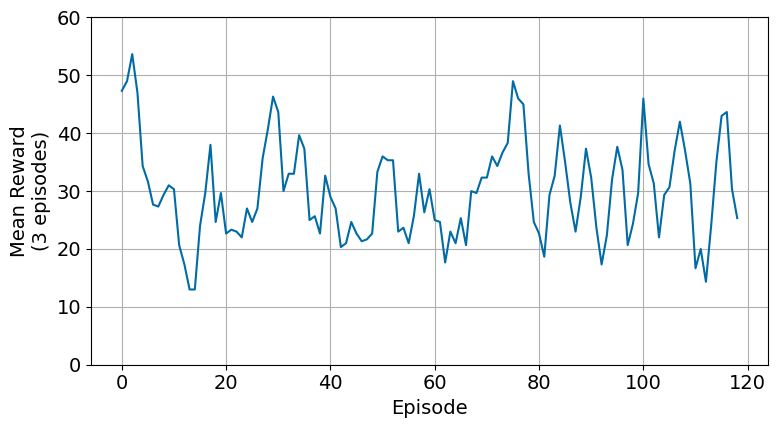

In [61]:
# Make plots
figs_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/"
model_name = 'result_advantage_critic_greedy'
kernel_size = 3
fig, ax = plot_episode_rewards(x, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

In [58]:
np.savetxt('/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_random_results', rewards, fmt='%d')

In [60]:
x = np.loadtxt('/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_random_results', dtype=float)

In [7]:

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
critic_load_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complete_critic_random.pth"
critic_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complete_critic_greedy.pth"
backbone_load_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complete_backbone_random.pth"
backbone_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complete_backbone_greedy.pth"
actor_load_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_actor_random.pth"
actor_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_actor_greedy.pth"


# Environment parameters
opponent_class = GreedyPlayer
opponent_is_white = True
apply_negative_scores = False

# Critic parameters
input_dim = 256 
hidden_dim = 256

# Actor parameters
input_dim = 256
hidden_dim = 256

# BackBone parameters
input_channels = 6
hidden_dimensions = 256
residual_blocks = 6


# Critic Learning parameters
num_previous_states = 6
epochs = 120
episodes_per_epoch = 2
batch_size = 4
learning_rate = 1e-3
gamma = 0.25
max_steps = 100
simple_critic = False


# Prioritized Memory Replay parameters
memory_size = 12
sampling_priority_scale = 0.7
replace_samples = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = -1

# Model Training
n_iterations = 1

################
# Training
################

for iteration in range(n_iterations):
    print(f"Starting training iteration {iteration + 1}/{n_iterations}")

    env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores)

    if critic_load_path is not None:
        critic = Critic(input_dim=input_dim, hidden_dim=hidden_dim, model_path=critic_load_path)
    else:
        critic = Critic(input_dim=input_dim, hidden_dim=hidden_dim)

    if backbone_load_path is not None:
        backbone = ResidualBackBone(input_channels=input_channels, hidden_dimensions=hidden_dimensions, residual_blocks=residual_blocks, model_path=backbone_load_path)
    else: 
        backbone = ResidualBackBone(input_channels=input_channels, hidden_dimensions=hidden_dimensions, residual_blocks=residual_blocks)
    
    if actor_load_path is not None:
        actor = Actor(input_dim=input_dim, hidden_dim=hidden_dim, model_path=actor_load_path)
    else:
        actor = Actor(input_dim=input_dim, hidden_dim=hidden_dim)

    critic.to(device)
    backbone.to(device)
    actor.to(device)

    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in critic.parameters():
            param.data = param.data.to(device='mps')

    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in backbone.parameters():
            param.data = param.data.to(device='mps')
    
    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in actor.parameters():
            param.data = param.data.to(device='mps')

    # Learning system initialization
    learning_system = AdvancedA2CLearning(env=env, 
                                    critic=critic, 
                                    backbone=backbone,
                                    actor=actor, 
                                    num_previous_states=num_previous_states, 
                                    device=device, 
                                    epochs=epochs,
                                    episodes_per_epoch=episodes_per_epoch,
                                    batch_size=batch_size,
                                    learning_rate=learning_rate,
                                    gamma=gamma,
                                    max_steps=max_steps,
                                    memory_size=memory_size,
                                    simple_critic=simple_critic
                                    )


    
    # Calculate the number of trainable parameters
    critic_num_parameters = count_parameters(critic) 
    print(f"Number of trainable parameters in the Critic model: {critic_num_parameters}")


    # Calculate the number of trainable parameters
    backbone_num_parameters = count_parameters(backbone) 
    print(f"Number of trainable parameters in the BackBone model: {backbone_num_parameters}")

    # Calculate the number of trainable parameters
    actor_num_parameters = count_parameters(actor)
    print(f"Number of trainable parameters in the Actor model: {actor_num_parameters}")

    # Training
    rewards, losses = learning_system.train(sampling_prob_scale=sampling_priority_scale, 
                                            replace_samples=replace_samples, 
                                            priority_offset=priority_offset,  
                                            importance_sampling_beta=importance_sampling_beta_start)

    #Save Model
    learning_system.save(critic_save_path, backbone_save_path, actor_save_path)

    print(f"Finished training iteration {iteration + 1}/{n_iterations}. Model saved.")

Device:  mps
Starting training iteration 1/1
Critic loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complete_critic_random.pth
BackBone loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complete_backbone_random.pth
Actor loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_actor_random.pth
Number of trainable parameters in the Critic model: 15927297
Number of trainable parameters in the BackBone model: 7474272
Number of trainable parameters in the Actor model: 18055257


KeyboardInterrupt: 

In [29]:

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
critic_load_path = None
critic_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complete_critic_random2.pth"
backbone_load_path = None
backbone_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complete_backbone_random2.pth"
actor_load_path = None
actor_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_actor_random2.pth"


# Environment parameters
opponent_class = RandomPlayer
opponent_is_white = True
apply_negative_scores = False

# Critic parameters
input_dim = 256 
hidden_dim = 256

# Actor parameters
input_dim = 256
hidden_dim = 256

# BackBone parameters
input_channels = 6
hidden_dimensions = 256
residual_blocks = 6


# Critic Learning parameters
num_previous_states = 6
epochs = 60
episodes_per_epoch = 2
batch_size = 4
learning_rate = 1e-4
gamma = 0.25
max_steps = 100
simple_critic = False


# Prioritized Memory Replay parameters
memory_size = 12
sampling_priority_scale = 0.7
replace_samples = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = -1

# Model Training
n_iterations = 1

################
# Training
################

for iteration in range(n_iterations):
    print(f"Starting training iteration {iteration + 1}/{n_iterations}")

    env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores)

    if critic_load_path is not None:
        critic = Critic(input_dim=input_dim, hidden_dim=hidden_dim, model_path=critic_load_path)
    else:
        critic = Critic(input_dim=input_dim, hidden_dim=hidden_dim)

    if backbone_load_path is not None:
        backbone = ResidualBackBone(input_channels=input_channels, hidden_dimensions=hidden_dimensions, residual_blocks=residual_blocks, model_path=backbone_load_path)
    else: 
        backbone = ResidualBackBone(input_channels=input_channels, hidden_dimensions=hidden_dimensions, residual_blocks=residual_blocks)
    
    if actor_load_path is not None:
        actor = Actor(input_dim=input_dim, hidden_dim=hidden_dim, model_path=actor_load_path)
    else:
        actor = Actor(input_dim=input_dim, hidden_dim=hidden_dim)

    critic.to(device)
    backbone.to(device)
    actor.to(device)

    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in critic.parameters():
            param.data = param.data.to(device='mps')

    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in backbone.parameters():
            param.data = param.data.to(device='mps')
    
    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in actor.parameters():
            param.data = param.data.to(device='mps')

    # Learning system initialization
    learning_system = AdvancedA2CLearning(env=env, 
                                    critic=critic, 
                                    backbone=backbone,
                                    actor=actor, 
                                    num_previous_states=num_previous_states, 
                                    device=device, 
                                    epochs=epochs,
                                    episodes_per_epoch=episodes_per_epoch,
                                    batch_size=batch_size,
                                    learning_rate=learning_rate,
                                    gamma=gamma,
                                    max_steps=max_steps,
                                    memory_size=memory_size,
                                    simple_critic=simple_critic
                                    )


    
    # Calculate the number of trainable parameters
    critic_num_parameters = count_parameters(critic) 
    print(f"Number of trainable parameters in the Critic model: {critic_num_parameters}")


    # Calculate the number of trainable parameters
    backbone_num_parameters = count_parameters(backbone) 
    print(f"Number of trainable parameters in the BackBone model: {backbone_num_parameters}")

    # Calculate the number of trainable parameters
    actor_num_parameters = count_parameters(actor)
    print(f"Number of trainable parameters in the Actor model: {actor_num_parameters}")

    # Training
    rewards, losses = learning_system.train(sampling_prob_scale=sampling_priority_scale, 
                                            replace_samples=replace_samples, 
                                            priority_offset=priority_offset,  
                                            importance_sampling_beta=importance_sampling_beta_start)

    #Save Model
    learning_system.save(critic_save_path, backbone_save_path, actor_save_path)

    print(f"Finished training iteration {iteration + 1}/{n_iterations}. Model saved.")

Device:  mps
Starting training iteration 1/1
Number of trainable parameters in the Critic model: 15927297
Number of trainable parameters in the BackBone model: 7474272
Number of trainable parameters in the Actor model: 18055257
Memory initialized with 12 episodes. Average steps per episode: 68.00, Average reward: 45.42
Critic Loss: 0.9899817705154419
Actor Loss: 0.026279829442501068
Critic Loss: 0.9899957180023193
Actor Loss: 0.010193939320743084
Critic Loss: 0.9473665952682495
Actor Loss: 0.037505701184272766
Critic Loss: 0.968747615814209
Actor Loss: 7.152557373046875e-07
Critic Loss: 0.9743563532829285
Actor Loss: -0.0
Critic Loss: 0.9884853959083557
Actor Loss: 0.00845985859632492
Critic Loss: 0.9891161918640137
Actor Loss: -3.317128118851542e-07
Critic Loss: 0.9899824261665344
Actor Loss: 2.670288097306184e-07
Critic Loss: 0.9761875867843628
Actor Loss: -3.633045082551689e-07
Critic Loss: 0.9821397662162781
Actor Loss: -2.7247838829680404e-07
Critic Loss: 0.9899775981903076
Actor 

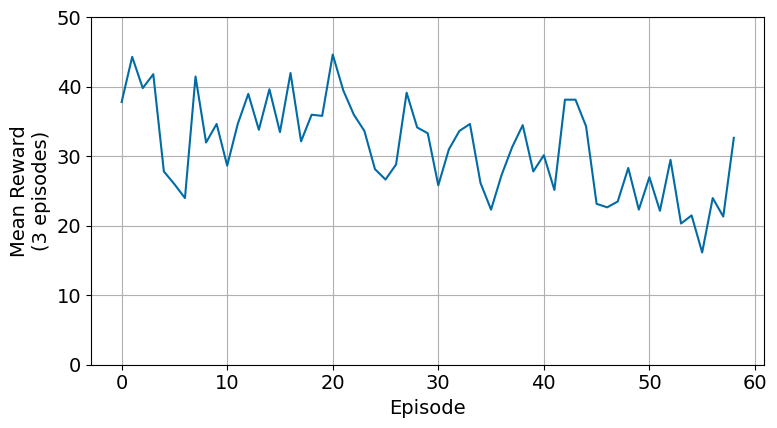

In [31]:
# Make plots
figs_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/"
model_name = 'result_advantage_critic_greedy'
kernel_size = 3
fig, ax = plot_episode_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()

In [33]:

##############
# Parameters
##############

# I/O parameters
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device: ", device)
critic_load_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complete_critic_random2.pth"
critic_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complete_critic_greedy2.pth"
backbone_load_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complete_backbone_random2.pth"
backbone_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complete_backbone_greedy2.pth"
actor_load_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_actor_random2.pth"
actor_save_path = "/Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_actor_greedy2.pth"


# Environment parameters
opponent_class = GreedyPlayer
opponent_is_white = True
apply_negative_scores = False

# Critic parameters
input_dim = 256 
hidden_dim = 256

# Actor parameters
input_dim = 256
hidden_dim = 256

# BackBone parameters
input_channels = 6
hidden_dimensions = 256
residual_blocks = 6


# Critic Learning parameters
num_previous_states = 6
epochs = 200
episodes_per_epoch = 2
batch_size = 4
learning_rate = 1e-4
gamma = 0.25
max_steps = 100
simple_critic = False


# Prioritized Memory Replay parameters
memory_size = 12
sampling_priority_scale = 0.7
replace_samples = False
priority_offset = 1e-5
update_buffer_after_forward = False
importance_sampling_beta_start = -1

# Model Training
n_iterations = 1

################
# Training
################

for iteration in range(n_iterations):
    print(f"Starting training iteration {iteration + 1}/{n_iterations}")

    env = HexChessEnv(opponent_class, opponent_is_white, apply_negative_scores=apply_negative_scores)

    if critic_load_path is not None:
        critic = Critic(input_dim=input_dim, hidden_dim=hidden_dim, model_path=critic_load_path)
    else:
        critic = Critic(input_dim=input_dim, hidden_dim=hidden_dim)

    if backbone_load_path is not None:
        backbone = ResidualBackBone(input_channels=input_channels, hidden_dimensions=hidden_dimensions, residual_blocks=residual_blocks, model_path=backbone_load_path)
    else: 
        backbone = ResidualBackBone(input_channels=input_channels, hidden_dimensions=hidden_dimensions, residual_blocks=residual_blocks)
    
    if actor_load_path is not None:
        actor = Actor(input_dim=input_dim, hidden_dim=hidden_dim, model_path=actor_load_path)
    else:
        actor = Actor(input_dim=input_dim, hidden_dim=hidden_dim)

    critic.to(device)
    backbone.to(device)
    actor.to(device)

    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in critic.parameters():
            param.data = param.data.to(device='mps')

    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in backbone.parameters():
            param.data = param.data.to(device='mps')
    
    # Convert model weights to MPS if necessary
    if torch.backends.mps.is_available():
        for param in actor.parameters():
            param.data = param.data.to(device='mps')

    # Learning system initialization
    learning_system = AdvancedA2CLearning(env=env, 
                                    critic=critic, 
                                    backbone=backbone,
                                    actor=actor, 
                                    num_previous_states=num_previous_states, 
                                    device=device, 
                                    epochs=epochs,
                                    episodes_per_epoch=episodes_per_epoch,
                                    batch_size=batch_size,
                                    learning_rate=learning_rate,
                                    gamma=gamma,
                                    max_steps=max_steps,
                                    memory_size=memory_size,
                                    simple_critic=simple_critic
                                    )


    
    # Calculate the number of trainable parameters
    critic_num_parameters = count_parameters(critic) 
    print(f"Number of trainable parameters in the Critic model: {critic_num_parameters}")


    # Calculate the number of trainable parameters
    backbone_num_parameters = count_parameters(backbone) 
    print(f"Number of trainable parameters in the BackBone model: {backbone_num_parameters}")

    # Calculate the number of trainable parameters
    actor_num_parameters = count_parameters(actor)
    print(f"Number of trainable parameters in the Actor model: {actor_num_parameters}")

    # Training
    rewards, losses = learning_system.train(sampling_prob_scale=sampling_priority_scale, 
                                            replace_samples=replace_samples, 
                                            priority_offset=priority_offset,  
                                            importance_sampling_beta=importance_sampling_beta_start)

    #Save Model
    learning_system.save(critic_save_path, backbone_save_path, actor_save_path)

    print(f"Finished training iteration {iteration + 1}/{n_iterations}. Model saved.")

Device:  mps
Starting training iteration 1/1
Critic loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complete_critic_random2.pth
BackBone loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_complete_backbone_random2.pth
Actor loaded from:  /Users/tawab/Desktop/columbia/Courses/Spring2024/Reinforcement Learning/project/can_chess_with_hexagons_rl/results/advanced_ac_actor_random2.pth
Number of trainable parameters in the Critic model: 15927297
Number of trainable parameters in the BackBone model: 7474272
Number of trainable parameters in the Actor model: 18055257
Memory initialized with 12 episodes. Average steps per episode: 9.83, Average reward: 1.00
Critic Loss: 0.9374122023582458
Actor Loss: -2.980232238769531e-07
Critic Loss: 0.4981852173805237
Actor Loss: -1.3828277587890625e-05
Critic Loss: 0.8570868968

### Critic Training

In [134]:
v1_1_rewards, v1_1_losses = rewards, losses

In [139]:
# Save results
model_name = "a2c_ps_random_conv_v1_1"
losses_df = pd.DataFrame(v1_1_losses)
np.savetxt(os.path.join(base_path, f"{model_name}_rewards.csv"), v1_1_rewards, delimiter=",")
losses_df.to_csv(os.path.join(base_path, f"{model_name}_losses.csv"), index=False)

In [165]:
# Load Results
model_name = "a2c_ps_random_conv_v1_1"
csv_losses_path = os.path.join(base_path, f"{model_name}_losses.csv")
csv_rewards_path = os.path.join(base_path, f"{model_name}_rewards.csv")
losses_df = pd.read_csv(csv_losses_path)
rewards = np.loadtxt(csv_rewards_path, delimiter=",")

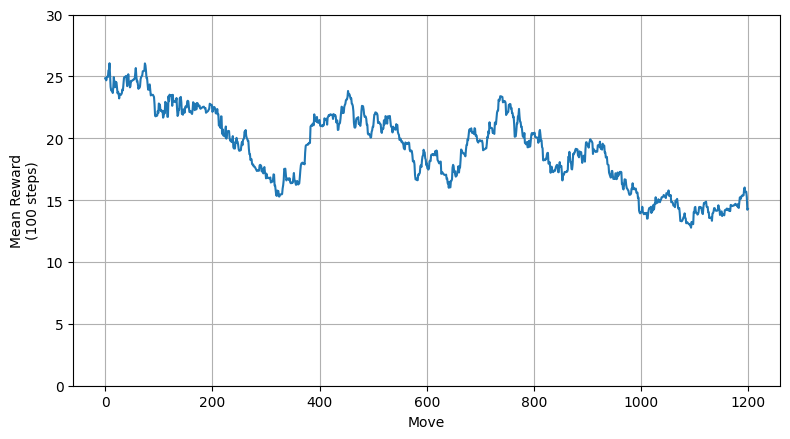

In [166]:
# Make plots
model_name = "a2c_ps_random_conv_v1_1"
kernel_size = 100
fig, ax = plot_step_rewards(rewards, kernel_size, save_path=os.path.join(figs_path, f"{model_name}_rewards.png"))
plt.show()